### This is the code to grid search the best parameters for the SARIMA model using autoarima
#### References: 
- Chaudhuri, S. (2023, October 26). Assessment of Accuracy Metrics for Time Series Forecasting. Analytics Vidhya. https://medium.com/analytics-vidhya/assessment-of-accuracy-metrics-for-time-series-forecasting-bc115b655705.  
Contribution: The logic for the accuracy metrics.
- Peixeiro, M. (2022). Time series forecasting in Python (Section 8.1). Manning.  
Contribution: The logic for residual analysis and the implementation of the Ljung-Box test.


#### Libraries
- Package Pandas (2.2). (2024). [Python]. https://pandas.pydata.org/
- Package NumPy (1.23). (2023). [Pyhton]. https://numpy.org/ - Harris, C. R., Millman, K. J., Van Der Walt, S. J., Gommers, R., Virtanen, P., Cournapeau, D., Wieser, E., Taylor, J., Berg, S., Smith, N. J., Kern, R., Picus, M., Hoyer, S., Van Kerkwijk, M. H., Brett, M., Haldane, A., Del Río, J. F., Wiebe, M., Peterson, P., … Oliphant, T. E. (2020). Array programming with NumPy. Nature, 585(7825), 357–362. https://doi.org/10.1038/s41586-020-2649-2
- Droettboom, J. D. H., Michael. (2024). Package matplotlib (3.8.4) [Python]. https://matplotlib.org
- Package scikit-learn (1.4). (2024). [Pyhton]. https://scikit-learn.org/stable/index.html
- Smith, T. G., & Others. (2017). Package pmdarima: ARIMA estimators for Python (2.0.4) [Python]. http://www.alkaline-ml.com/pmdarima
- Package statsmodels (0.14). (2024). [Python]. statsmodels. https://github.com/statsmodels/statsmodels


In [2]:
# Importing libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pmdarima import auto_arima
from sklearn.metrics import (mean_absolute_error,
                             mean_absolute_percentage_error,
                             mean_squared_error)
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

import useful_functions as uf

In [19]:
# load the data
file_path = '../data/data_orig_parameters.csv'

# parse the date column and set it as the index of the dataframe
df_raw = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date', )
target_variable = df_raw.columns[0]
df = df_raw[[target_variable]]

# Convert the index as date
df.index = pd.to_datetime(df.index)

# To remove outliers,define the threshold from 0 to 1 - float
#emove_outliers_threshold = np.nan
#remove_outliers_threshold = 0.05
#remove_outliers_threshold = 0.10
#remove_outliers_threshold = 0.15
remove_outliers_threshold = 0.20

# Define test and validation set sizes
test_size = 48 # months

In [20]:
# Check the threshold and remove outliers if it is defined
if not pd.isna(remove_outliers_threshold):
    df_to_be_cleaned = df.copy()
    df_cleaned = uf.remove_outliers(df_to_be_cleaned, threshold=remove_outliers_threshold)
else: # if the threshold is NaN, use the original data
    df_cleaned = df.copy()

# Fill missing values with the mean of the previous and next values
df_adjusted = uf.fill_missing_values(df_cleaned)


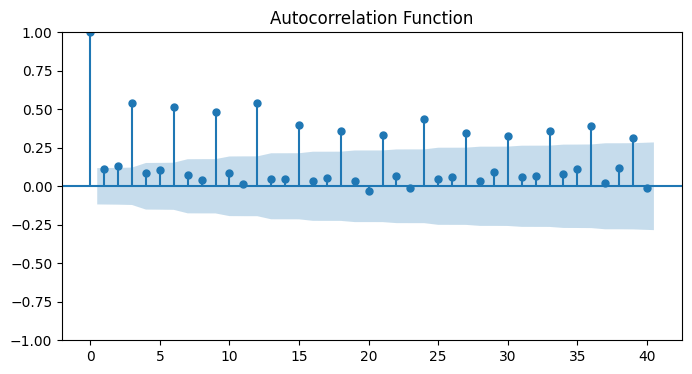

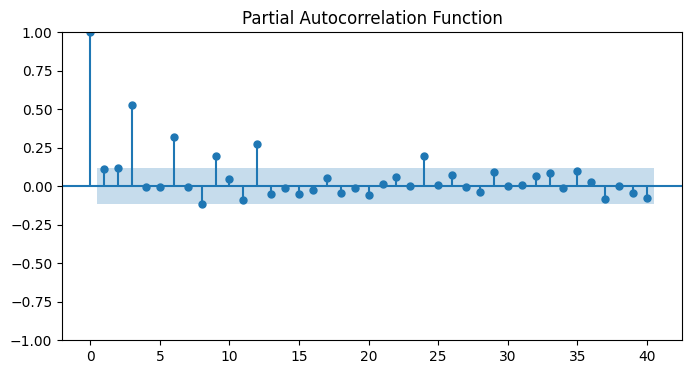

In [21]:
# Plot ACF and PACF to evaluate the series


import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot the ACF
plt.figure(figsize=(8, 4))
plot_acf(df_adjusted[target_variable], ax=plt.gca(), lags=40)  # You can adjust the number of lags
plt.title('Autocorrelation Function')

# Plot the PACF
plt.figure(figsize=(8, 4))
plot_pacf(df_adjusted[target_variable], ax=plt.gca(), lags=40)  # You can adjust the number of lags
plt.title('Partial Autocorrelation Function')

plt.show()





In [22]:
# Let's check if the series is stationary

# Augmented Dickey-Fuller test
ad_fuller_result = adfuller(df_adjusted.iloc[:,0])
# Print the test statistic and the p-value
print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}') # if p-value < 0.05, we reject the null hypothesis (H0), the data is stationary

ADF Statistic: -1.1647404285192648
p-value: 0.6885766869477302


In [23]:
# Given the data is not stationary, we need to difference the series 

# Check if you need to difference the series more than once and compute the ADF test
#df_diff = df_adjusted[target_variable].diff().diff(periods=12).dropna()

# In case you only need to difference the series once, define if it is seasonal or not
df_diff = df_adjusted[target_variable].diff().dropna()
#df_diff = df_adjusted[target_variable].diff(periods=12).dropna()

ad_fuller_result = adfuller(df_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')


ADF Statistic: -9.299385126082722
p-value: 1.1231880913945603e-15


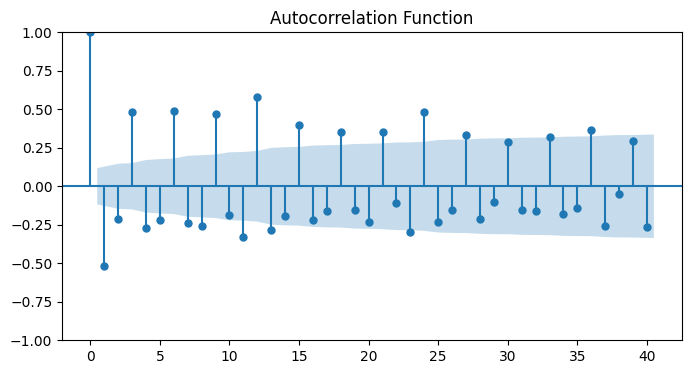

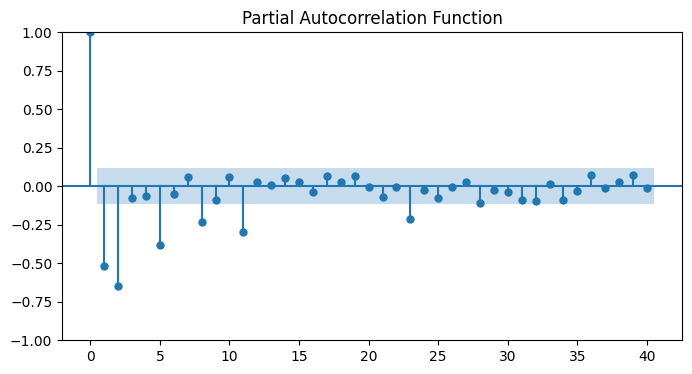

In [24]:
# Plot the ACF
plt.figure(figsize=(8, 4))
plot_acf(df_diff, ax=plt.gca(), lags=40)  # You can adjust the number of lags
plt.title('Autocorrelation Function')

# Plot the PACF
plt.figure(figsize=(8, 4))
plot_pacf(df_diff, ax=plt.gca(), lags=40)  # You can adjust the number of lags
plt.title('Partial Autocorrelation Function')

plt.show()


In [25]:
# Split the data into train and test sets

df_train = df_adjusted[:-test_size]
df_test = df_adjusted[-test_size:]

In [26]:
### Run this code to find the best parameters for the SARIMA model using autorima

# Autorima function grids the hyperparameters and finds the best model
# auto_model = auto_arima(df_train[target_variable], 
#                                 start_p=0, 
#                                 start_q=0, # initial values for p and q
#                                 max_p=12, 
#                                 max_q=12, # maximum values for p and q
#                                 m=12, # seasonal period
#                                 start_P=0, 
#                                 start_Q=0, # initial values for P and Q
#                                 max_P=12, 
#                                 max_Q=12, # maximum values for P and Q
#                                 seasonal=True, # seasonal model
#                                 d=1, D=None,  # non-seasonal and seasonal differences based on ADF test above
#                                 trace=False, # print results
#                                 error_action='ignore', # ignore orders that don't work 
#                                 suppress_warnings=True, # suppress warnings
#                                 stepwise=True, # apply stepwise search
#                                 max_order=10) # maximum order 

# # Adjust the model with the best parameters
# model = SARIMAX(df_train, order=auto_model.order, seasonal_order=auto_model.seasonal_order)
model = SARIMAX(df_train, order=(5,1,4), seasonal_order=(2,0,0,12))

g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [27]:
# Adjust the model with the best parameters and train it

# In case you want to test a specific set of parameters
#model = SARIMAX(df_train, order=(5, 1, 4), seasonal_order=(2, 0, 0, 12))
model_fit = model.fit(disp=False, maxiter=200)

# Predict for the test period
predictions_SARIMA = model_fit.forecast(steps=len(df_test))

g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
g:\My Drive\Data_Projects\MDS\master_thesis\fiscal-balance-forecast\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [28]:
# Print the model summary
print(model_fit.summary())

                                      SARIMAX Results                                      
Dep. Variable:             ECO_fiscal_result_month   No. Observations:                  228
Model:             SARIMAX(5, 1, 4)x(2, 0, [], 12)   Log Likelihood               -2362.667
Date:                             Tue, 23 Apr 2024   AIC                           4749.333
Time:                                     10:21:10   BIC                           4790.433
Sample:                                 01-01-2001   HQIC                          4765.918
                                      - 12-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2895      0.511     -0.566      0.571      -1.291       0.712
ar.L2         -0.2268      

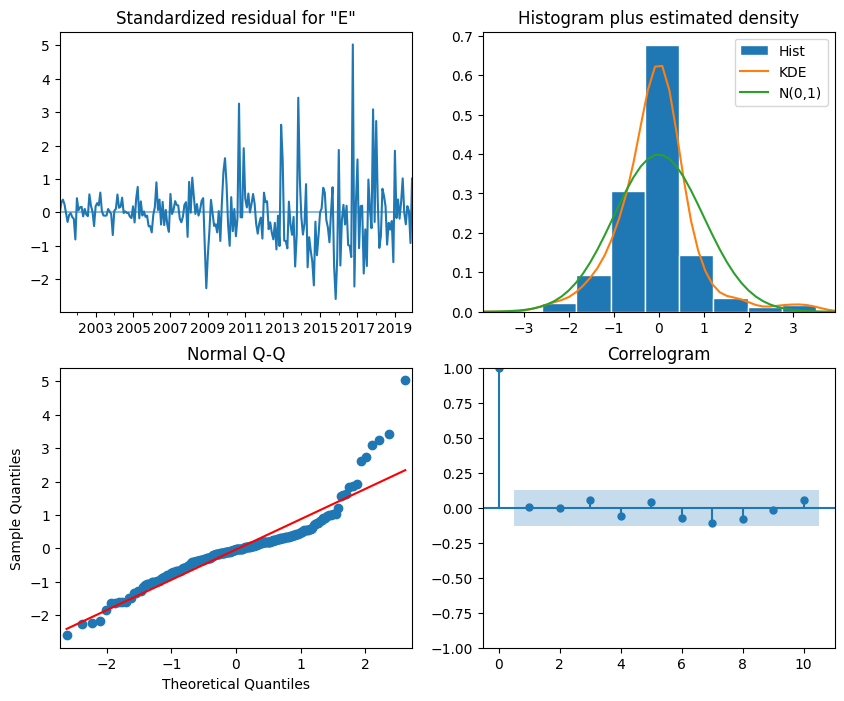

In [29]:
# Let's plot the residuals diagnostics to check if they are uncorrelated
# Define the plot figure size
plt.rcParams["figure.figsize"] = (10,8)
model_fit.plot_diagnostics();

In [30]:
# Let's plot the residuals diagnostics to check if they are uncorrelated
# Define the plot figure size
plt.rcParams["figure.figsize"] = (8,4)

All values are above 0.05. The residuals are uncorrelated


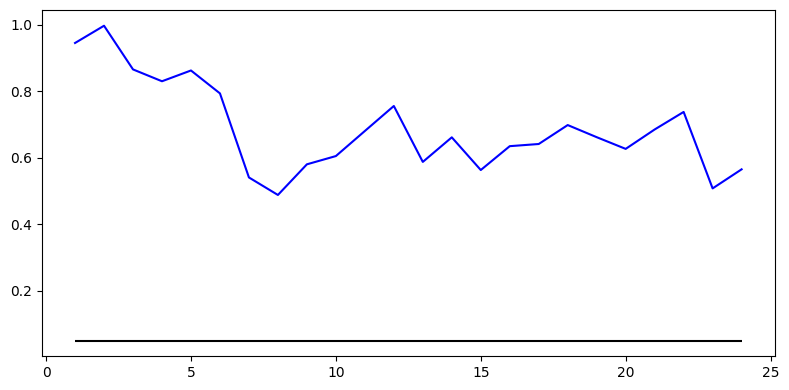

In [31]:
# Define a ljung box test method to check for autocorrelation in the residuals
def ljung_box_test(residuals, is_seasonal, period):
    
    if is_seasonal: # if the residuals are seasonal 
        lb_df = acorr_ljungbox(residuals, period=period) # period is the seasonal period
    else: # if the residuals are not seasonal
        max_lag = min([10, len(residuals)/5]) # maximum lag
        lb_df = acorr_ljungbox(residuals, np.arange(1, max_lag+1, 1))

    fig, ax = plt.subplots()
    ax.plot(lb_df['lb_pvalue'], 'b-', label='p-values')
    ax.hlines(y=0.05, xmin=1, xmax=len(lb_df), color='black') # Threshold line at 0.05 - p-value significance level
    plt.tight_layout()
    
    if all(pvalue > 0.05 for pvalue in lb_df['lb_pvalue']):
        print('All values are above 0.05. The residuals are uncorrelated')
    else:
        print('At least one p-value is smaller than 0.05')

# Use ljung box test to check for autocorrelation in the residuals.
residuals = model_fit.resid
# 
ljung_box_test(residuals, is_seasonal=True, period=12)

In [32]:
# Evaluate the model 

mape_SARIMA_auto = mean_absolute_percentage_error(df_test, predictions_SARIMA)
rmse_SARIMA_auto = np.sqrt(mean_squared_error(df_test, predictions_SARIMA))
mae_SARIMA_auto = mean_absolute_error(df_test, predictions_SARIMA)
print(f'MAPE SARIMA AUTO: {mape_SARIMA_auto:.2f}')
print(f'RMSE SARIMA AUTO: {rmse_SARIMA_auto:.2f}')
print(f'MAE SARIMA AUTO: {mae_SARIMA_auto:.2f}')

MAPE SARIMA AUTO: 2.26
RMSE SARIMA AUTO: 19416.24
MAE SARIMA AUTO: 16010.54


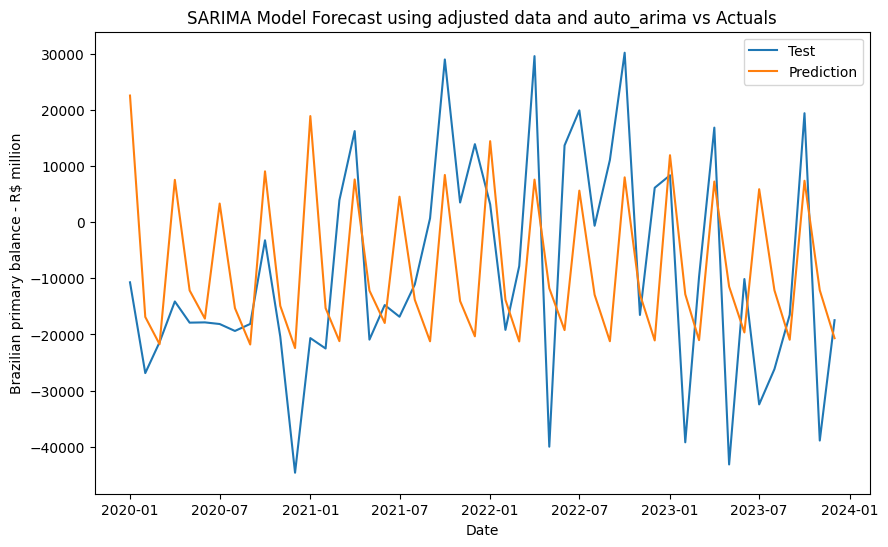

In [33]:
# Plot SARIMAX Model Forecast(auto_arima) vs Actuals

# Plot the forecast using function plot_prediction_vs_test from useful_functions
uf.plot_prediction_vs_test(
    target_variable, # Brazilian PB
    df_test[target_variable], # Test data
    predictions_SARIMA, # Predictions
    'SARIMA Model Forecast using adjusted data and auto_arima vs Actuals')